# purpose
0. compare the absolute number of stop codons on each reading frame
0. compare the pressure on stop codons on each reading frame


## prerequisite
* .gff (parsed by BCBio)
* .fasta x2

In [3]:
from BCBio import GFF
from Bio import SeqIO
import Bio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
gffFilepath = "GCF_000242335.1_ASM24233v3_genomic.gff"
cds_lst=[]
with open(gffFilepath) as f:
    for rec in GFF.parse(f,target_lines=1):
        assert len(rec.features)==1
        if rec.features[0].type=="CDS":
            cds_lst.append(rec)
print("{} CDSs are loaded".format(len(cds_lst)))

2564 CDSs are loaded


In [29]:
def get_osc_df(seqFilepath, cds_lst):
    """ get Outframe stop codon dataframe based on .fasta & corresponding cds_lst"""
    
    def find_codons(seq,codons,frame=1):
        """find designated codons on designated reading frame(1~6)"""
        
        assert frame in [1,2,3,4,5,6]
        assert len(seq)%3==0
        
        shift=(frame-1)%3    
        loopCount=int(len(seq)/3)
        if shift>0:
            loopCount-=1
        if frame>=4:
            codons=[Bio.Seq.Seq(codon).reverse_complement() for codon in codons]

        pos_lst=[]
        for i in range(loopCount):
            idx=3*i+shift
            codon=str(seq[idx:idx+3])
            if codon in codons:
                pos_lst.append(idx)
        return pos_lst
    
    
    
    #read fasta file
    seqRec_lst=[]
    for seqRec in SeqIO.parse(seqFilepath, "fasta"):
        seqRec_lst.append(seqRec)
    print("DONE reading fasta")
    
    #extract each cds reagions
    subSeq_lst=[]
    for cds in cds_lst:
        subSeq=None
        for seqRec in seqRec_lst:
            if cds.id==seqRec.id:
                subSeq=(cds.features[0].extract(seqRec)).seq
        if subSeq is not None:
            subSeq_lst.append(subSeq)
        else:
            print("No corresponding id : {}".format(cds.id))
    print("DONE extracting cds")
            
    
    #find codons
    dct_lst=[]
    for i,subSeq in enumerate(subSeq_lst):
        if i%100==0:
            print("\tProcessing {0}/{1}".format(i, len(subSeq_lst)))
        
        dct={}
        dct["length"]=len(subSeq)
        if len(subSeq)%3==0 and len(subSeq)>=6:#defined as typical cds
            for frame in range(1,7):
                pos_lst=find_codons(subSeq, codons=["TAA","TAG","TGA"],frame=frame)
                relPos_lst=[pos/len(subSeq) for pos in pos_lst]

                dct["frame{}_num".format(frame)]=int(len(pos_lst))
                dct["frame{}_per".format(frame)]=len(pos_lst)*3/len(subSeq)
                dct["frame{}_pos".format(frame)]=":".join([str(pos) for pos in pos_lst])
                dct["frame{}_rel".format(frame)]=":".join([str(pos) for pos in relPos_lst])
        dct_lst.append(dct)
    print("DONE finding codons")
        
        
    #format dataframe
    df= pd.DataFrame(dct_lst) 
    columns_lst=["length"]
    for frame in range(1,7):
        columns_lst.append("frame{}_num".format(frame))
        columns_lst.append("frame{}_per".format(frame))
    for frame in range(1,7):
        columns_lst.append("frame{}_pos".format(frame))
        columns_lst.append("frame{}_rel".format(frame))
    df=df[columns_lst]
    return df

In [30]:
real_df= get_osc_df("GCF_000242335.1_ASM24233v3_chromosome.fna", cds_lst)
print(real_df.shape)
real_df.head()
#sim_df = get_osc_df("/data/mitsuki/out/altorf/genome/fasta/GCF_000022125.1_ASM2212v1_chromosome_simu03_0.fna", cds_lst)

DONE reading fasta
No corresponding id : NC_019961.1
No corresponding id : NC_019961.1
No corresponding id : NC_019961.1
No corresponding id : NC_019961.1
No corresponding id : NC_019961.1
No corresponding id : NC_019969.1
No corresponding id : NC_019969.1
No corresponding id : NC_019969.1
No corresponding id : NC_019969.1
DONE extracting cds
	Processing 0/2555
	Processing 100/2555
	Processing 200/2555
	Processing 300/2555
	Processing 400/2555
	Processing 500/2555
	Processing 600/2555
	Processing 700/2555
	Processing 800/2555
	Processing 900/2555
	Processing 1000/2555
	Processing 1100/2555
	Processing 1200/2555
	Processing 1300/2555
	Processing 1400/2555
	Processing 1500/2555
	Processing 1600/2555
	Processing 1700/2555
	Processing 1800/2555
	Processing 1900/2555
	Processing 2000/2555
	Processing 2100/2555
	Processing 2200/2555
	Processing 2300/2555
	Processing 2400/2555
	Processing 2500/2555
DONE finding codons
(2555, 25)


,length,frame1_num,frame1_per,frame2_num,frame2_per,frame3_num,frame3_per,frame4_num,frame4_per,frame5_num,...,frame2_pos,frame2_rel,frame3_pos,frame3_rel,frame4_pos,frame4_rel,frame5_pos,frame5_rel,frame6_pos,frame6_rel
0,1032,1.0,0.002907,8.0,0.023256,5.0,0.014535,1.0,0.002907,24.0,...,1:112:211:241:412:448:634:706,0.0009689922480620155:0.10852713178294573:0.20...,14:44:56:230:932,0.013565891472868217:0.04263565891472868:0.054...,678,0.6569767441860465,19:91:220:247:253:301:331:409:454:463:499:529:...,0.018410852713178296:0.08817829457364341:0.213...,179:377:395:548:971:995,0.17344961240310078:0.3653100775193798:0.38275...
1,1491,1.0,0.002012,17.0,0.034205,0.0,0.000000,2.0,0.004024,36.0,...,10:55:136:367:613:730:796:817:823:829:841:931:...,0.00670690811535882:0.03688799463447351:0.0912...,,,9:15,0.006036217303822937:0.01006036217303823,22:46:67:70:178:274:289:331:397:442:478:490:49...,0.014755197853789403:0.03085177733065057:0.044...,38:74:146:152:182:209:245:338:416:425:500:545:...,0.025486250838363516:0.04963112005365526:0.097...
2,1233,1.0,0.002433,15.0,0.036496,1.0,0.002433,0.0,0.000000,31.0,...,184:190:232:283:301:415:619:652:913:979:1012:1...,0.1492295214922952:0.154095701540957:0.1881589...,995,0.8069748580697486,,,7:34:151:181:211:244:298:346:355:382:418:433:4...,0.0056772100567721:0.027575020275750203:0.1224...,11:59:89:488:779:839:1034:1100:1115,0.008921330089213302:0.047850770478507706:0.07...
3,1254,1.0,0.002392,14.0,0.033493,7.0,0.016746,1.0,0.002392,27.0,...,49:79:106:115:226:319:370:391:514:592:664:853:...,0.03907496012759171:0.06299840510366826:0.0845...,212:578:587:689:941:974:1040,0.16905901116427433:0.4609250398724083:0.46810...,225,0.17942583732057416,4:193:208:313:343:418:469:631:652:673:676:700:...,0.003189792663476874:0.15390749601275916:0.165...,182:335:350:353:359:560:584:620:830:875:1025:1...,0.14513556618819776:0.2671451355661882:0.27910...
4,4404,1.0,0.000681,74.0,0.050409,45.0,0.030654,6.0,0.004087,77.0,...,7:25:73:151:202:214:232:277:355:391:397:430:56...,0.001589464123524069:0.005676657584014532:0.01...,683:776:965:1040:1109:1457:1466:1601:1622:1688...,0.155086285195277:0.17620345140781107:0.219118...,48:510:957:960:3978:4146,0.010899182561307902:0.11580381471389646:0.217...,94:157:220:247:265:340:370:490:622:640:643:703...,0.02134423251589464:0.03564940962761126:0.0499...,113:260:269:380:452:485:593:650:671:680:737:89...,0.025658492279745686:0.05903723887375113:0.061...


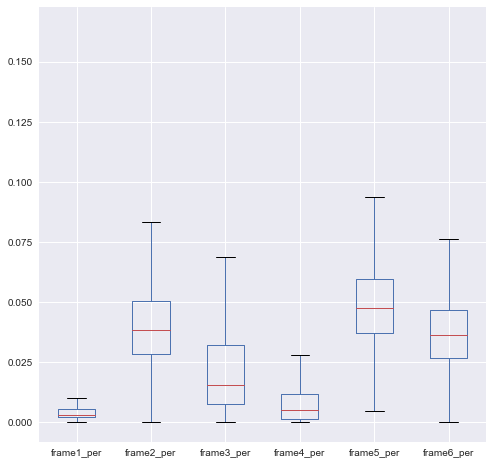

In [37]:
plt.figure(figsize=(8,8))
real_df.boxplot(column=["frame1_per","frame2_per","frame3_per","frame4_per","frame5_per","frame6_per"])
plt.show()

In [38]:
sim_df= get_osc_df("GCF_000242335.1_ASM24233v3_chromosome_simu03_0.fna", cds_lst)
print(sim_df.shape)
sim_df.head()

DONE reading fasta
No corresponding id : NC_019961.1
No corresponding id : NC_019961.1
No corresponding id : NC_019961.1
No corresponding id : NC_019961.1
No corresponding id : NC_019961.1
No corresponding id : NC_019969.1
No corresponding id : NC_019969.1
No corresponding id : NC_019969.1
No corresponding id : NC_019969.1
DONE extracting cds
	Processing 0/2555
	Processing 100/2555
	Processing 200/2555
	Processing 300/2555
	Processing 400/2555
	Processing 500/2555
	Processing 600/2555
	Processing 700/2555
	Processing 800/2555
	Processing 900/2555
	Processing 1000/2555
	Processing 1100/2555
	Processing 1200/2555
	Processing 1300/2555
	Processing 1400/2555
	Processing 1500/2555
	Processing 1600/2555
	Processing 1700/2555
	Processing 1800/2555
	Processing 1900/2555
	Processing 2000/2555
	Processing 2100/2555
	Processing 2200/2555
	Processing 2300/2555
	Processing 2400/2555
	Processing 2500/2555
DONE finding codons
(2555, 25)


,length,frame1_num,frame1_per,frame2_num,frame2_per,frame3_num,frame3_per,frame4_num,frame4_per,frame5_num,...,frame2_pos,frame2_rel,frame3_pos,frame3_rel,frame4_pos,frame4_rel,frame5_pos,frame5_rel,frame6_pos,frame6_rel
0,1032,1.0,0.002907,15.0,0.043605,17.0,0.049419,4.0,0.011628,17.0,...,1:34:211:220:301:403:412:454:541:598:706:724:8...,0.0009689922480620155:0.03294573643410853:0.20...,14:56:92:113:143:419:488:551:611:641:683:713:7...,0.013565891472868217:0.05426356589147287:0.089...,177:510:540:1020,0.17151162790697674:0.4941860465116279:0.52325...,91:142:247:253:331:409:463:499:529:574:760:808...,0.08817829457364341:0.1375968992248062:0.23934...,98:167:353:395:548:971,0.09496124031007752:0.1618217054263566:0.34205...
1,1491,1.0,0.002012,29.0,0.058350,11.0,0.022133,2.0,0.004024,33.0,...,10:22:46:70:136:178:268:442:478:529:571:595:63...,0.00670690811535882:0.014755197853789403:0.030...,206:215:344:428:548:566:632:893:1085:1394:1439,0.1381623071763917:0.1441985244802146:0.230717...,594:1140,0.3983903420523139:0.7645875251509054,67:205:214:274:289:331:367:397:490:496:508:559...,0.04493628437290409:0.1374916163648558:0.14352...,38:74:146:152:338:416:425:584:650:689:767:803:...,0.025486250838363516:0.04963112005365526:0.097...
2,1233,1.0,0.002433,22.0,0.053528,6.0,0.014599,6.0,0.014599,29.0,...,34:37:151:184:211:301:355:382:415:448:652:718:...,0.027575020275750203:0.030008110300081103:0.12...,113:392:434:590:947:1088,0.09164639091646391:0.31792376317923765:0.3519...,120:381:762:909:996:1011,0.09732360097323602:0.30900243309002434:0.6180...,7:106:181:244:283:298:346:361:412:418:433:454:...,0.0056772100567721:0.08596918085969181:0.14679...,11:89:488:1100:1229,0.008921330089213302:0.07218167072181671:0.395...
3,1254,1.0,0.002392,22.0,0.052632,22.0,0.052632,3.0,0.007177,24.0,...,4:49:79:106:121:199:274:319:370:430:514:523:59...,0.003189792663476874:0.03907496012759171:0.062...,59:134:248:308:344:365:392:419:458:497:635:656...,0.04704944178628389:0.10685805422647528:0.1977...,429:702:864,0.34210526315789475:0.5598086124401914:0.68899...,58:115:130:193:208:226:313:343:391:418:469:631...,0.046251993620414676:0.09170653907496013:0.103...,182:302:353:494:560:584:620:791:830:1025:1247:...,0.14513556618819776:0.24082934609250398:0.2814...
4,4404,1.0,0.000681,57.0,0.038828,53.0,0.036104,13.0,0.008856,86.0,...,25:94:151:157:232:355:391:430:445:508:556:589:...,0.005676657584014532:0.02134423251589464:0.034...,11:86:131:134:194:314:323:404:467:605:776:932:...,0.002497729336966394:0.01952770208900999:0.029...,15:387:960:1098:1980:2352:2598:3213:3243:3387:...,0.0034059945504087193:0.08787465940054497:0.21...,10:70:130:139:214:220:247:265:340:370:490:514:...,0.002270663033605813:0.01589464123524069:0.029...,161:260:269:452:482:485:593:680:734:737:926:99...,0.036557674841053586:0.05903723887375113:0.061...


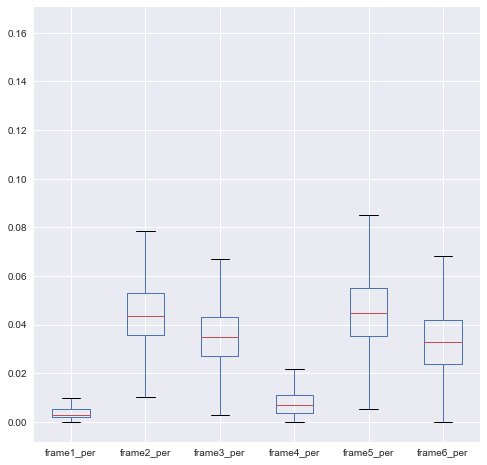

In [39]:
plt.figure(figsize=(8,8))
sim_df.boxplot(column=["frame1_per","frame2_per","frame3_per","frame4_per","frame5_per","frame6_per"])
plt.show()

In [41]:
df=pd.concat([real_df,sim_df],axis=1, keys=["real", "sim"])

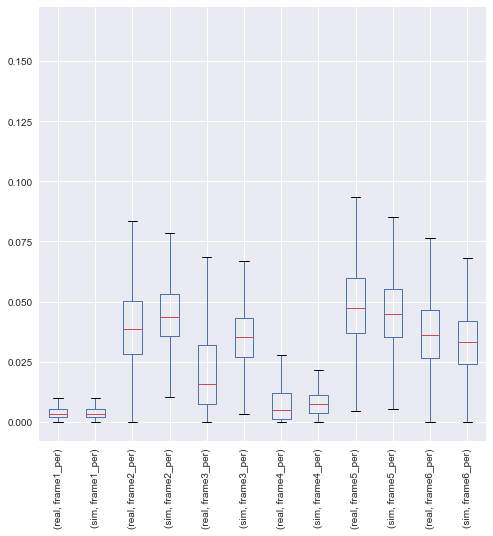

In [50]:
columns_lst=[]
for frame in range(1,7):
    columns_lst.append(("real", "frame{}_per".format(frame)))
    columns_lst.append(("sim", "frame{}_per".format(frame)))


plt.figure(figsize=(8,8))
df.boxplot(column=columns_lst)
plt.xticks(rotation=90)
plt.show()

In [51]:
for key, row in df.iterrows():
    

(2555, 50)

In [57]:
for frame in range(1,7):
    clm="frame{}_num".format(frame)
    outClm="frame{}_pres".format(frame)
    df[outClm]=(df[("real", clm)]+1)/(df[("sim", clm)]+1)

In [52]:
df["test"]="test"

In [58]:
df.head()

real                                                                    \
  length frame1_num frame1_per frame2_num frame2_per frame3_num frame3_per   
0   1032        1.0   0.002907        8.0   0.023256        5.0   0.014535   
1   1491        1.0   0.002012       17.0   0.034205        0.0   0.000000   
2   1233        1.0   0.002433       15.0   0.036496        1.0   0.002433   
3   1254        1.0   0.002392       14.0   0.033493        7.0   0.016746   
4   4404        1.0   0.000681       74.0   0.050409       45.0   0.030654   

                                       ...      \
  frame4_num frame4_per frame5_num     ...       
0        1.0   0.002907       24.0     ...       
1        2.0   0.004024       36.0     ...       
2        0.0   0.000000       31.0     ...       
3        1.0   0.002392       27.0     ...       
4        6.0   0.004087       77.0     ...       

                                                 sim  \
                                          frame5_rel   
0  0.08817829457364341:0.1375968992248062:0.23934...   
1  0.04493628437290409:0.1374916163648558:0.14352...   
2  0.0056772100567721:0.08596918085969181:0.14679...   
3  0.046251993620414676:0.09170653907496013:0.103...   
4  0.002270663033605813:0.01589464123524069:0.029...   

                                                      \
                                          frame6_pos   
0                             98:167:353:395:548:971   
1  38:74:146:152:338:416:425:584:650:689:767:803:...   
2                                11:89:488:1100:1229   
3  182:302:353:494:560:584:620:791:830:1025:1247:...   
4  161:260:269:452:482:485:593:680:734:737:926:99...   

                                                      test frame1_pres  \
                                          frame6_rel                     
0  0.09496124031007752:0.1618217054263566:0.34205...  test         1.0   
1  0.025486250838363516:0.04963112005365526:0.097...  test         1.0   
2  0.008921330089213302:0.07218167072181671:0.395...  test         1.0   
3  0.14513556618819776:0.24082934609250398:0.2814...  test         1.0   
4  0.036557674841053586:0.05903723887375113:0.061...  test         1.0   

  frame2_pres frame3_pres frame4_pres frame5_pres frame6_pres  
                                                               
0    0.562500    0.333333    0.400000    1.388889    1.000000  
1    0.600000    0.083333    1.000000    1.088235    1.269231  
2    0.695652    0.285714    0.142857    1.066667    1.666667  
3    0.652174    0.347826    0.500000    1.120000    1.076923  
4    1.293103    0.851852    0.500000    0.896552    1.193548  

[5 rows x 57 columns]

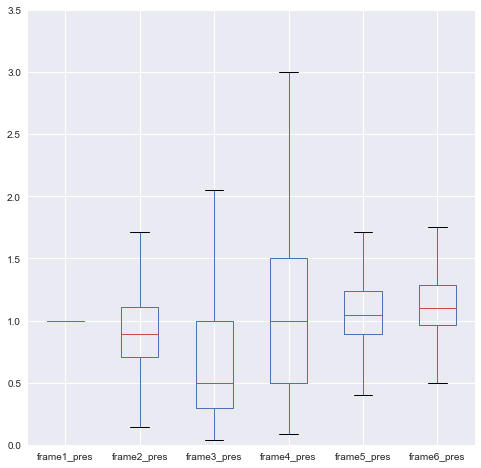

In [63]:
plt.figure(figsize=(8,8))
df.boxplot(column=["frame1_pres","frame2_pres","frame3_pres","frame4_pres","frame5_pres","frame6_pres"])
plt.ylim((0,3.5))
plt.show()

In [18]:
cds_lst[0].features

[SeqFeature(FeatureLocation(ExactPosition(371), ExactPosition(1403), strand=1), type='CDS', id='cds0')]

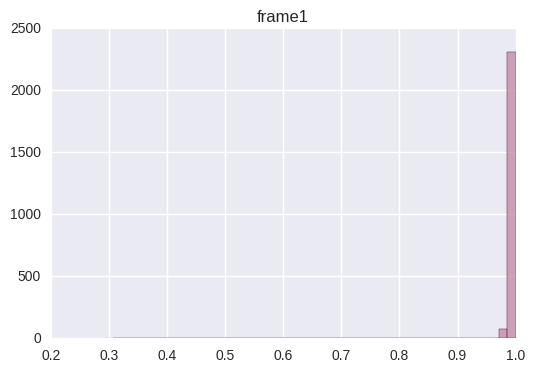

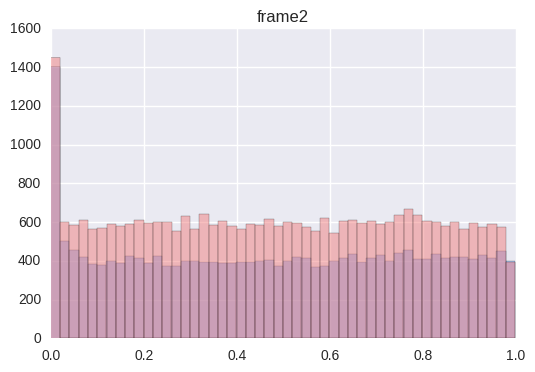

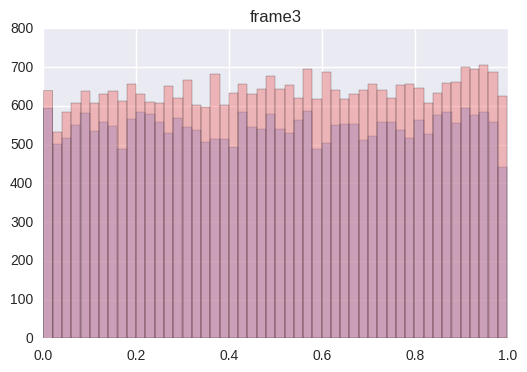

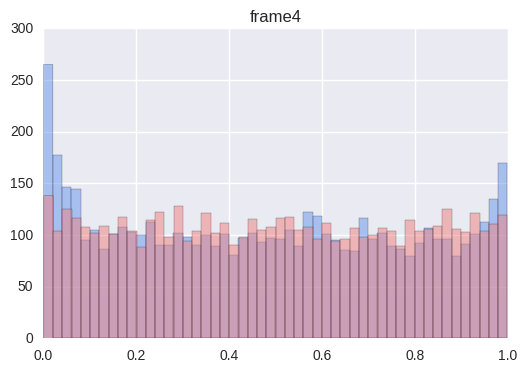

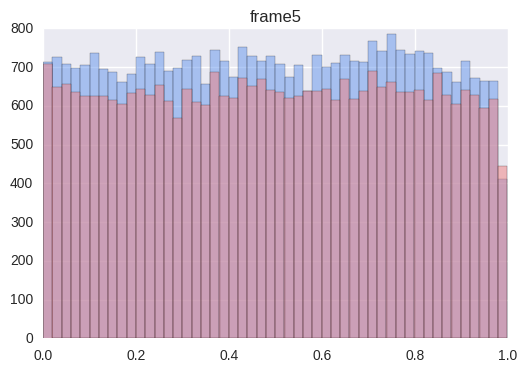

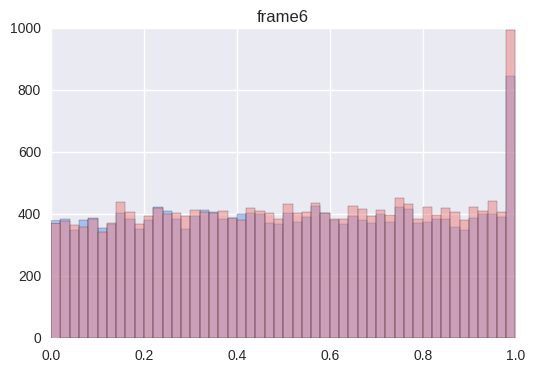

In [83]:
for frame in range(1,7):
    color_lst=["#6495ED","#F08080"]
    for i,df in enumerate((real_df,sim_df)):
        total_lst=[]
        for lst in df["frame{}_rel".format(frame)].dropna():
            if len(lst)>0:
                total_lst+=[float(pos) for pos in lst.split(",")]
        sns.distplot(total_lst, kde=False, rug=False, bins=50,hist_kws={"color":color_lst[i], "alpha":.5})
        plt.title("frame{}".format(frame))
    plt.show()

In [73]:
sim_df.head()

,frame1,frame1_rel,frame2,frame2_rel,frame3,frame3_rel,frame4,frame4_rel,frame5,frame5_rel,frame6,frame6_rel,length
0,222,0.9866666666666667,"1,73,91,205","0.0044444444444444444,0.3244444444444444,0.404...",95,0.4222222222222222,,,"70,94,103,151","0.3111111111111111,0.4177777777777778,0.457777...",77,0.3422222222222222,225
1,1503,0.99800796812749,"1,52,82,91,370,547,598,616,724,988,1045,1069,1...","0.0006640106241699867,0.034528552456839307,0.0...","131,155,191,254,287,329,353,383,440,458,527,56...","0.08698539176626827,0.10292164674634795,0.1268...","105,420,450,954,1326","0.0697211155378486,0.2788844621513944,0.298804...","130,439,481,505,586,628,685,715,721,823,859,94...","0.08632138114209828,0.2915006640106242,0.31938...","146,164,410,470,734,773,797,842,884,923,992,10...","0.09694555112881806,0.10889774236387782,0.2722...",1506
2,324,0.9908256880733946,133,0.40672782874617736,"77,86,128,146","0.23547400611620795,0.26299694189602446,0.3914...",249,0.7614678899082569,"22,52,76,85,145,235","0.0672782874617737,0.15902140672782875,0.23241...","140,158,203,218,272","0.42813455657492355,0.4831804281345566,0.62079...",327
3,1371,0.9978165938864629,"481,520,664,670,772,826,931,1000,1078,1132,128...","0.3500727802037846,0.3784570596797671,0.483260...","5,20,32,200,227,356,422,641,785,818,839,911,10...","0.00363901018922853,0.01455604075691412,0.0232...","306,969,1200","0.22270742358078602,0.7052401746724891,0.87336...","4,73,187,346,379,490,805,862,904,994,1024,1039...","0.002911208151382824,0.05312954876273653,0.136...","596,623,752,1013,1043,1235,1271","0.43377001455604075,0.4534206695778748,0.54730...",1374
4,1152,0.9974025974025974,"1,13,58,130,133,196,295,478,517,541,592,619,65...","0.0008658008658008658,0.011255411255411256,0.0...","44,104,224,269,284,317,338,356,443,647,698,707...","0.0380952380952381,0.09004329004329005,0.19393...","330,438","0.2857142857142857,0.37922077922077924","7,28,43,103,157,355,382,460,547,658,706,751,83...","0.006060606060606061,0.024242424242424242,0.03...","80,170,206,314,524,527,611,728,740,1088,1133","0.06926406926406926,0.1471861471861472,0.17835...",1155


In [16]:
dct_lst=[]
for subSeq in subSeq_lst:
    dct={}
    dct["length"]=len(subSeq)
    if len(subSeq)%3==0 and len(subSeq)>6:
        for frame in range(1,7):
            pos_lst=find_codons(subSeq, codons=["TAA","TAG","TGA"],frame=frame)
            relPos_lst=[pos/len(subSeq) for pos in pos_lst]
            
            dct["frame{}".format(frame)]=",".join([str(pos) for pos in pos_lst])
            dct["frame{}_rel".format(frame)]=",".join([str(pos) for pos in relPos_lst])
            
    dct_lst.append(dct)

In [63]:
df=pd.DataFrame(dct_lst)
df.head(10)

,frame1,frame1_rel,frame2,frame2_rel,frame3,frame3_rel,frame4,frame4_rel,frame5,frame5_rel,frame6,frame6_rel,length
0,222,0.9866666666666667,1,0.0044444444444444444,"98,116","0.43555555555555553,0.5155555555555555",,,"61,70,91,94,103,151,205","0.27111111111111114,0.3111111111111111,0.40444...","11,77,125","0.04888888888888889,0.3422222222222222,0.55555...",225
1,1503,0.99800796812749,"1,337,370,505,526,715,934,988,1069","0.0006640106241699867,0.22377158034528552,0.24...","92,155,251,287,329,353,362,383,458,515,590,728...","0.06108897742363878,0.10292164674634795,0.1666...","9,255,933,1155","0.00597609561752988,0.1693227091633466,0.61952...","91,418,481,628,685,721,823,859,940,949,961,103...","0.06042496679946879,0.2775564409030544,0.31938...","269,410,431,470,536,644,773,797,842,851,884,99...","0.17861885790172644,0.27224435590969454,0.2861...",1506
2,324,0.9908256880733946,"133,145","0.40672782874617736,0.4434250764525994",128,0.39143730886850153,"93,201,210","0.28440366972477066,0.6146788990825688,0.64220...","22,52,235","0.0672782874617737,0.15902140672782875,0.71865...",41,0.12538226299694188,327
3,1371,0.9978165938864629,"4,100,481,490,520,664,673,772,805,955,1024,112...","0.002911208151382824,0.07278020378457059,0.350...","164,296,320,356,422,446,551,599,641,815,839,93...","0.11935953420669577,0.21542940320232898,0.2328...","954,984","0.6943231441048034,0.7161572052401747","73,139,187,277,346,670,862,904,931,994,1000,10...","0.05312954876273653,0.10116448326055313,0.1360...","224,419,473,596,623,893,1235","0.16302765647743814,0.3049490538573508,0.34425...",1374
4,1152,0.9974025974025974,"1,43,196,295,328,382,478,502,652,688,706,754,7...","0.0008658008658008658,0.03722943722943723,0.16...","14,17,140,269,368,443,518,578,641,647,794,1049...","0.012121212121212121,0.01471861471861472,0.121...",246,0.21298701298701297,"7,13,28,58,103,130,136,157,436,451,517,547,592...","0.006060606060606061,0.011255411255411256,0.02...","167,347,404,611,728,740,863,947,1007,1088,1133...","0.1445887445887446,0.30043290043290044,0.34978...",1155
5,2403,0.9987531172069826,"97,298,403,475,574,691,931,1087,1126,1369,1417...","0.04031587697423109,0.12385702410640066,0.1674...","149,158,230,254,326,422,428,470,488,530,545,58...","0.06192851205320033,0.0656691604322527,0.09559...","102,552,2310","0.04239401496259352,0.22942643391521197,0.9600...","46,190,196,220,295,382,409,481,523,604,619,700...","0.019118869492934332,0.07896924355777224,0.081...","29,134,287,338,440,563,599,662,794,896,1094,14...","0.012053200332502078,0.05569409808811305,0.119...",2406
6,2565,0.9988317757009346,"25,31,211,628,712,793,811,1024,1222,1537,1636,...","0.009735202492211837,0.012071651090342679,0.08...","38,98,107,170,206,218,251,335,548,590,608,611,...","0.014797507788161994,0.0381619937694704,0.0416...",,,"76,79,115,136,466,496,616,769,772,832,856,901,...","0.029595015576323987,0.030763239875389408,0.04...","125,167,224,356,437,656,662,689,785,950,1091,1...","0.04867601246105919,0.06503115264797507,0.0872...",2568
7,912,0.9967213114754099,"508,823,904","0.5551912568306011,0.8994535519125683,0.987978...","14,56,260,275,383,458,476,542,644,665,674,746,833","0.015300546448087432,0.06120218579234973,0.284...","492,720","0.5377049180327869,0.7868852459016393","7,28,340,454,574,652,868","0.007650273224043716,0.030601092896174863,0.37...","266,503,611,773","0.2907103825136612,0.5497267759562842,0.667759...",915
8,1401,0.9978632478632479,"1,112,514,520,568,697,739,928,1000,1024,1027,1...","0.0007122507122507123,0.07977207977207977,0.36...","5,35,41,122,140,185,314,389,395,437,506,593,60...","0.0035612535612535613,0.02492877492877493,0.02...","1185,1395","0.844017094017094,0.9935897435897436","4,115,136,328,379,403,454,499,694,850,958,1006...","0.002849002849002849,0.08190883190883191,0.096...","32,62,74,209,230,284,467,485,545,743,788,875,9...","0.022792022792022793,0.04415954415954416,0.052...",1404
9,1248,0.9976019184652278,"1,127,475,811,940,1060,1171","0.00079936051159072

In [66]:
total_lst=[]
for lst in df["frame3_rel"].dropna():
    if len(lst)>0:
        total_lst+=[float(pos) for pos in lst.split(",")]

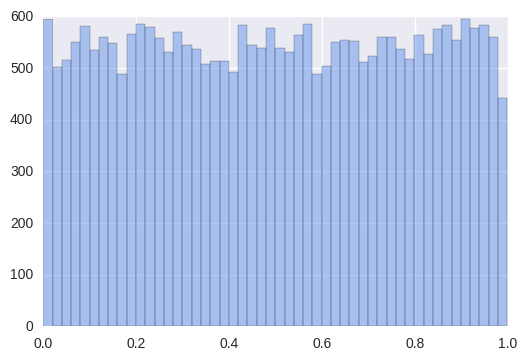

In [67]:
sns.distplot(total_lst, kde=False, rug=False, bins=50,hist_kws={"color":"#6495ED", "alpha":.5})

In [51]:
float(lst)

0.9866666666666667

In [46]:
total_lst

['0.9866666666666667',
 '0.99800796812749',
 '0.9908256880733946',
 '0.9978165938864629',
 '0.9974025974025974',
 '0.9987531172069826',
 '0.9988317757009346',
 '0.9967213114754099',
 '0.9978632478632479',
 '0.9976019184652278',
 '0.9984076433121019',
 '0.9942196531791907',
 '0.9970414201183432',
 '0.9965753424657534',
 '0.9981024667931688',
 '0.9967213114754099',
 '0.9926470588235294',
 '0.9961977186311787',
 '0.9926470588235294',
 '0.9961832061068703',
 '',
 '0.9938650306748467',
 '0.9991489361702127',
 '0.9970238095238095',
 '0.9986754966887417',
 '0.9970501474926253',
 '0.997289972899729',
 '0.9954337899543378',
 '0.9982905982905983',
 '0.9873417721518988',
 '0.9971428571428571',
 '0.9931506849315068',
 '0.996969696969697',
 '0.9955555555555555',
 '0.9846153846153847',
 '0.993006993006993',
 '0.996969696969697',
 '0.9936305732484076',
 '0.9982817869415808',
 '0.9978902953586498',
 '0.9967532467532467',
 '0.9943502824858758',
 '0.9896907216494846',
 '0.9920634920634921',
 '0.99668874

In [40]:
np.nan
lst

nan

In [35]:
type(lst)

float

In [13]:
type(df["frame0_rel"])

pandas.core.series.Series

In [ ]:
print(subSeq)

In [ ]:
find_codons(subSeq,codons=["TAA","TAG","TGA"],frame=6)

In [ ]:
subSeq_lst[2]

In [ ]:
len(cds_lst)

In [ ]:
rec_lst[2].features

In [ ]:
type(rec_lst[0])

In [ ]:
type(rec.features[0].location)

In [ ]:
dir(rec.features[0].location)

In [ ]:
import Bio
help(Bio.SeqFeature)

In [ ]:
seqRec_lst

In [ ]:
feature=rec.features[0]
feature

In [ ]:
subSeq=feature.extract(seqRec_lst[0])

In [ ]:
seqRec=Bio.SeqRecord.SeqRecord("ATGC")

In [ ]:
feature.extract(seqRec)

In [ ]:
seqRec_lst[0].id

In [ ]:
rec_lst[0].id

In [ ]:
type(rec_lst[0])

In [ ]:
rec_lst[0]

In [ ]:
dir(seqRec_lst)

In [ ]:
seqRec_lst[0